# 因子分析基础

## 引入常用库

In [3]:
# 导入需要的数据库
from jqfactor import *
from jqdata import *
import pandas as pd
from collections import OrderedDict  #保持Key的顺序
from datetime import datetime,date,timedelta
import matplotlib.pyplot as plt # 画图用
import pickle  # 打包

plt.style.use('ggplot')  # 设置图表风格

import warnings  
warnings.filterwarnings('ignore') 

## 工具API

In [2]:
# 获取日期列表
# 获取每月末，季末，半年期期末日期
def get_tradeday_list(start,end,frequency=None,count=None):
    '''
    satrt,end:str yyyy-mm-dd
    frequency:str month,quarter,halfyear
    ------------
    return:list
        type:str
    '''
    if count != None:
        df = get_price('000001.XSHG',end_date=end,count=count)
    else:
        df = get_price('000001.XSHG',start_date=start,end_date=end)
    if frequency == None or frequency =='day':
        return list(map(lambda x:x.strftime('%Y-%m-%d'),df.index))
    else:
        df['year-month'] = [str(i)[0:7] for i in df.index]
        if frequency == 'month':
            return list(map(lambda x:x.strftime('%Y-%m-%d'),df.drop_duplicates('year-month',keep='last').index))
        elif frequency == 'quarter':
            df['month'] = [str(i)[5:7] for i in df.index]
            df = df[(df['month']=='03') | (df['month']=='06') | (df['month']=='09') | (df['month']=='12') ]
            list(map(lambda x:x.strftime('%Y-%m-%d'),df.drop_duplicates('year-month',keep='last').index))
        elif frequency =='halfyear':
            df['month'] = [str(i)[5:7] for i in df.index]
            df = df[(df['month']=='06') | (df['month']=='12')]
            return list(map(lambda x:x.strftime('%Y-%m-%d'),df.drop_duplicates('year-month',keep='last').index))


# 获取回测区间内每个交易日满足筛选条件的股票池
def get_stocks(index,traDate):
    '''
    index:str 指数代码
    traDate:str yyyy-mm-dd
    -------
    return:list 返回成分股中剔除st后的股票
    '''
    index_stocks_all=get_index_stocks(index, date=traDate) # 获取指数成分股
    # 除去成分股中的ST股票
    is_st=get_extras('is_st', index_stocks_all, end_date=traDate, count=1).iloc[0]
    unst_stocks=is_st[is_st!=True].index.tolist() # 获取不为st的股票
    # 筛选大于1年的股票
    stock_list=[]
    traDate=datetime.strptime(traDate,'%Y-%m-%d').date()
    for stock in unst_stocks:
        start_date = get_security_info(stock).start_date
        if start_date < (traDate - timedelta(days=365)):
            stock_list.append(stock)
    # 过滤掉当日停牌的股票
    ## 得到是否停牌信息的dataframe，停牌的1，未停牌得0
    suspened_info_df=get_price(stock_list,end_date=traDate,count=1,fields='paused')['paused'].T
    ## 过滤停牌股票
    unsuspened_index = suspened_info_df.iloc[:,0]<1
    ## # 得到当日未停牌股票的代码list
    unsuspened_stocks = suspened_info_df[unsuspened_index].index
    
    return list(unsuspened_stocks)

### ===初始化====

In [3]:
# 设置起止时间
## 中证开始日期为2007-01-15
start='2007-01-15'
end='2019-07-01'

#获取日期列表
date_list = get_tradeday_list(start=start,end=end,frequency='month')#获取回测日期间的所有交易日

print('date_list:\n%s'%(date_list))
print('-'*80)

date_list:
['2007-01-31', '2007-02-28', '2007-03-30', '2007-04-30', '2007-05-31', '2007-06-29', '2007-07-31', '2007-08-31', '2007-09-28', '2007-10-31', '2007-11-30', '2007-12-28', '2008-01-31', '2008-02-29', '2008-03-31', '2008-04-30', '2008-05-30', '2008-06-30', '2008-07-31', '2008-08-29', '2008-09-26', '2008-10-31', '2008-11-28', '2008-12-31', '2009-01-23', '2009-02-27', '2009-03-31', '2009-04-30', '2009-05-27', '2009-06-30', '2009-07-31', '2009-08-31', '2009-09-30', '2009-10-30', '2009-11-30', '2009-12-31', '2010-01-29', '2010-02-26', '2010-03-31', '2010-04-30', '2010-05-31', '2010-06-30', '2010-07-30', '2010-08-31', '2010-09-30', '2010-10-29', '2010-11-30', '2010-12-31', '2011-01-31', '2011-02-28', '2011-03-31', '2011-04-29', '2011-05-31', '2011-06-30', '2011-07-29', '2011-08-31', '2011-09-30', '2011-10-31', '2011-11-30', '2011-12-30', '2012-01-31', '2012-02-29', '2012-03-30', '2012-04-27', '2012-05-31', '2012-06-29', '2012-07-31', '2012-08-31', '2012-09-28', '2012-10-31', '2012-11

### ===原始计算因子数据===

- 进行因子值函数定义
- 循环日期获取因子值


股票价格的动量（Momentum） ， 顾名思义代表的是股价在一定时间内延续前期走势的现象。 不过与海外长期的研究和经验相悖的是， 在 A 股市场， 我们发现股价的反转（Reverse） 效应要远强于动量效应， 且短期反转因子的历史收益非常出色。

但常用动量因子也存在单调性不佳， 多头收益不稳定的问题， 因此参考研报我们尝试从不同角度出发对动量因子进行改造， 寻找提升常用动量因子选股
效果和稳定性的方法。


在该多因子系列报告中， 曾给出过动量类因子的因子测试结论， 报告中测试的几个常用动量因子，也是我们经常接触到的基础动量因子，明细如下

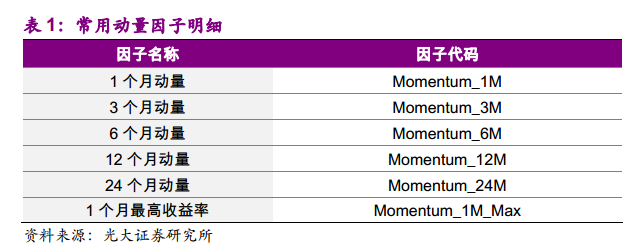


根据研报的观点，动量（反转） 效应的成因是投资者认识出现偏差，对信息的解读不够及时充分。 也可以认为动量（反转） 效应是来自于投资者认知偏差或者说噪音交易行为。

由此可以推测， 散户集中程度或者说流动性因素是影响动量因子效果的一个重要变量。 因此， 我们会自然的联想到采用截面中性化的方法， 将衡量散户集中程度的流动性因素从原始动量因子中剥离。

我们在构造因子时按申万一级行,对数流通市值对因子进行中性化处理。

下面我们将以统计周期为20,60,120,240,480日的动量因子为例进行探索演示

- 测试区间：2017-01-15至2019-07-01
- 股票池：中证500成分股(剔除选股日ST股票;剔除上市不满一年的股票;过滤掉当日停牌的股票)
- 因子中性化：市值、申万一级行业
- 调仓频率：月度

In [4]:
## 提取数据并计算动量因子-获取基础动量因子
def get_momentum_factor(dates,N,neutralize_=True): 
    '''
    N：int
    输入参数N为各调仓日前推N日的交易日期,dates为回测期内各个月末交易日（也就是调仓日）
    dates:list
    neutralize:bool 是否中性化
    -------------
    return:DataFrame
    已中性化momentum_N,risk数据：按申万一级行,对数流通市值中性化
    数据结构：
    |index-date|index-code|values-returns|values-risk|
    '''
    dict_=OrderedDict() # 创建每期存取数据字典
    
    for date in dates:
        
        stocks=get_stocks('000905.XSHG',date)  # 提取各交易日的成分股中满足筛选条件的股票池
        # step1:计算股票过去N日的收益率
        ## 提取各股票过去N个交易日的涨跌幅，即为过去N日内的收益率
        close=get_price(stocks,end_date=date,count=N,fields='close').close
        # 计算对数收益率
        log_ret=np.log(close)
        log_ret=log_ret.diff() #df
        # N日收益率=基础动量因子
        returns=log_ret.sum() #series
        
        # step2:计算股票过去N日的收益波动率，即日收益率的标准差
        # 提取股票过去N日的收益波动率
        sigma=log_ret.std() #series
        sigma.name='risk'
        
        # 是否中性化
        if neutralize_:
            # 收益按申万一级行,对数流通市值中性化因子
            returns_neutralize=neutralize(returns,how=['sw_l1','ln_circulating_market_cap'],date=date,fillna='sw_l1')
            returns_neutralize.name='returns'
        else:
            returns_neutralize=returns
            returns_neutralize.name='returns'
    
        # step3:计算升级动量因子
        data=pd.concat([returns_neutralize,sigma],axis=1,join='inner')  #将收益率与风险合并
        data['momentum']=data['returns']-3000*(data['risk']**2)  #计算动量因子
        
        print(date,'success')
        dict_[datetime.strptime(date,"%Y-%m-%d")]=data
        
    datas=pd.concat(dict_.values(),keys=dict_.keys())
    datas.index.names=['date','codes']
    return datas

In [6]:
# 此处数据提取需花费较多时间
## 将基础版动量策略的原始数据存入数据文件中，便于后期读取
momentum_1M_datas=get_momentum_factor(date_list,20,False)  
momentum_3M_datas=get_momentum_factor(date_list,60,False)  
momentum_6M_datas=get_momentum_factor(date_list,120,False)  
momentum_12M_datas=get_momentum_factor(date_list,240,False)  
momentum_24M_datas=get_momentum_factor(date_list,480,False)  

# 构建字典
k=['1M','3M','6M','12M','24M']
v=[momentum_1M_datas,momentum_3M_datas,momentum_6M_datas,
   momentum_12M_datas,momentum_24M_datas]
momentum_factor=dict(zip(k,v))

# 把计算出的因子数据写入文件 方便后续调用
pkl_file = open('momentum_factor.pkl', 'wb')
pickle.dump(momentum_factor, pkl_file, 0)

In [4]:
# 读取因子数据文件
pkl_file = open('momentum_factor.pkl', 'rb')
momentum_factor = pickle.load(pkl_file)
pkl_file.close()

# 数据一览
print('momentum_1M_datas\n\n','-'*40,'\n',momentum_factor['1M'].head(),'\n')
print('momentum_3M_datas\n\n','-'*40,'\n',momentum_factor['3M'].head(),'\n')
print('momentum_6M_datas\n\n','-'*40,'\n',momentum_factor['6M'].head(),'\n')
print('momentum_12M_datas\n\n','-'*40,'\n',momentum_factor['12M'].head(),'\n')
print('momentum_24M_datas\n\n','-'*40,'\n',momentum_factor['24M'].head(),'\n')

momentum_1M_datas

 ---------------------------------------- 
                          returns      risk  momentum
date       codes                                    
2007-01-31 000006.XSHE -0.134222  0.010151 -0.443372
           000016.XSHE  0.134819  0.006959 -0.010449
           000028.XSHE  0.214434  0.008959 -0.026373
           000032.XSHE  0.180670  0.007696  0.002975
           000033.XSHE  0.217269  0.006701  0.082546 

momentum_3M_datas

 ---------------------------------------- 
                          returns      risk  momentum
date       codes                                    
2007-01-31 000006.XSHE  0.214890  0.014258 -0.395001
           000016.XSHE  0.104360  0.009273 -0.153609
           000028.XSHE  0.270524  0.012218 -0.177326
           000032.XSHE  0.170818  0.009664 -0.109344
           000033.XSHE  0.144656  0.010459 -0.183495 

momentum_6M_datas

 ---------------------------------------- 
                          returns      risk  momentum
date       c

# 因子效果检查


我们将通过如下三个方面进行因子效果检查

1.IC信息比率

2.分组收益

3.换手率

在收益分析中, 分位数的平均收益， 第一分位数的因子值最小， 第十分位数的因子值最大。

分位数收益： 表示持仓1月后，各分位数可以获得的平均收益。


## 基础动量因子

In [7]:
# 使用获取的因子值进行单因子分析
## 设置调仓周期
periods=20 # (5,10,20)
## 设置分层数量
quantiles=10
## 分析
far_1M = analyze_factor(factor=momentum_factor['1M'].loc[:,'returns'], start_date=start, end_date=end, weight_method='avg', industry='sw_l1', quantiles=quantiles, periods=periods)
far_3M = analyze_factor(factor=momentum_factor['3M'].loc[:,'returns'], start_date=start, end_date=end, weight_method='avg', industry='sw_l1', quantiles=quantiles, periods=periods)
far_6M = analyze_factor(factor=momentum_factor['6M'].loc[:,'returns'], start_date=start, end_date=end, weight_method='avg', industry='sw_l1', quantiles=quantiles, periods=periods)
far_12M = analyze_factor(factor=momentum_factor['12M'].loc[:,'returns'], start_date=start, end_date=end, weight_method='avg', industry='sw_l1', quantiles=quantiles, periods=periods)
far_24M = analyze_factor(factor=momentum_factor['24M'].loc[:,'returns'], start_date=start, end_date=end, weight_method='avg', industry='sw_l1', quantiles=quantiles, periods=periods)


In [8]:
# 因子分析字典
k=['1M','3M','6M','12M','24M']
v=[far_1M,far_3M,far_6M,far_12M,far_24M]
basic_far=dict(zip(k,v))
# 保存分析后的数据
pkl_file = open('basic_far.pkl', 'wb')
pickle.dump(basic_far, pkl_file, 0)

In [5]:
# 读取分析文件
pkl_file = open('basic_far.pkl', 'rb')
basic_far = pickle.load(pkl_file)
pkl_file.close()

### IC分析

In [10]:
# 计算M1,M3,M6,M12,M24的IC Mean
ic_mean_m1=basic_far['1M'].calc_mean_information_coefficient(method='rank')
ic_mean_m3=basic_far['3M'].calc_mean_information_coefficient(method='rank')
ic_mean_m6=basic_far['6M'].calc_mean_information_coefficient(method='rank')
ic_mean_m12=basic_far['12M'].calc_mean_information_coefficient(method='rank')
ic_mean_m24=basic_far['24M'].calc_mean_information_coefficient(method='rank')

In [11]:
ic_mean=pd.concat([ic_mean_m1,ic_mean_m3,ic_mean_m6,ic_mean_m12,ic_mean_m24],axis=1)
ic_mean.columns=['M1','M3','M6','M12','M24']
print('各因子分组IC Mean情况\n','-'*60,'\n',ic_mean,'\n','-'*60)

各因子分组IC Mean情况
 ------------------------------------------------------------ 
                  M1       M3        M6       M12       M24
period_20 -0.066641 -0.07017 -0.052533 -0.052422 -0.052505 
 ------------------------------------------------------------


由下图为M1,M3,M6,M12,M24动量因子的IC Mean图表，整体上看，动量因子在中证500中均有显著的反向收益，既前期涨幅越高的股票，未来一个月收益表现越差。

无论是长周期(M24)还是短周期(M1),都具有显著的负向预测效果，且IC Mean均小于0.04。

"\nplt.figure(2,figsize=(12,5))\nplt.bar(ic_mean.columns,ic_mean.values[1],align='center', alpha=0.5)\nplt.title('period10 IC_MEAN',fontsize=18)\nplt.figure(3,figsize=(12,5))\nplt.bar(ic_mean.columns,ic_mean.values[2],align='center', alpha=0.5)\nplt.title('period20 IC_MEAN',fontsize=18)\n"

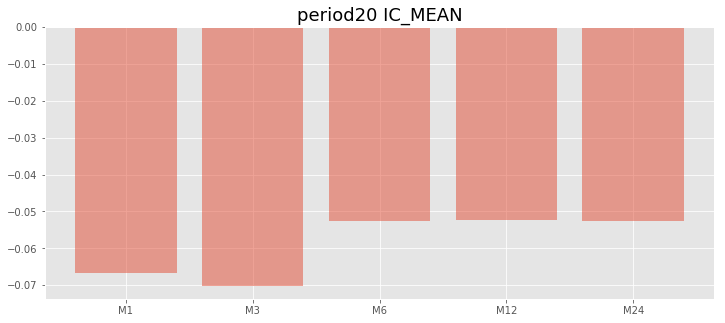

In [12]:
# 对IC Mean信息画图
plt.figure(1,figsize=(12,5))
plt.bar(ic_mean.columns,ic_mean.values[0],align='center', alpha=0.5)
plt.title('IC_MEAN',fontsize=18)

### 动量因子测试数据汇总表

In [6]:
# 汇总因子测试数据
def factor_report(far):
    '''
    far:为因子分析后的数据类型
    ---------
    return:dataframe
    '''
    # 获取最大百分位组减最小百分位组的收益率及标准差(超额收益)
    mean, std = far.compute_mean_returns_spread (by_date=False, demeaned=1)
    # 计算每组的夏普-按调仓
    longshort_sharpe=mean/std
    # 计算Mono_score(超额收益)
    ## 因子为升序排列10因子最大，1最小，研报中10组为降序
    ## MONO_Score，主要组别情况
    Numerator_mean, _ = far.compute_mean_returns_spread (upper_quant=1,lower_quant=10,by_date=False,demeaned=1)
    Denominator_mean,_=far.compute_mean_returns_spread (upper_quant=3,lower_quant=8,by_date=False, demeaned=1)
    MONO_Score=Numerator_mean/Denominator_mean
    # IC_IR
    IC_IR=far.calc_mean_information_coefficient(method='rank')
    IC=far.calc_mean_information_coefficient(method='normal')
    # 换手率
    ## 计算每组持仓的平均换手率
    v=[]
    data_dic=far.quantile_turnover
    periods=data_dic.keys()
    for period in periods:
        temp=data_dic[period].mean()
        v.append(temp.mean())
    turnover=pd.Series(v,index=periods)
    report=pd.concat([IC,IC_IR,longshort_sharpe,MONO_Score,turnover],axis=1)
    report.columns=['IC','IC_IR','LongShort_sharpe','MONO_Score','Turnover']
    return report

# 查看持仓周期报告
def trans2period(fardic,period):
    '''
    fardic:dic,key为far名称,为far数据
    period：为调仓周期
    ---------
    return:dataframe
    '''
    rList=[]
    for farname,farvalue in fardic.items():
        r_x=factor_report(farvalue).loc['period_'+str(period)]
        r_x.name=farname
        rList.append(r_x)
    datas=pd.concat(rList,axis=1)
    return datas.T

调仓周期为5,10,20天的测试结果如下,从表格中我们可以看到无论哪个持仓周期，结果均为：动量因子(反正因子)3M的收益率较高,多空收益的稳定性较差，因子单调性(MONO_Score)不太稳定，换手率较高。

**PS:MONO_Score的构造为（第1组年化收益-10组年化收益）/（3组年化收益-8组年化收益**

In [51]:
# 各因子获取20日调仓周期因子回测数据
trans2period(basic_far,20)

,IC,IC_IR,LongShort_sharpe,MONO_Score,Turnover
1M,-0.045512,-0.066641,-7.728916,2.012446,0.930497
3M,-0.051130,-0.070170,-8.563511,3.274893,0.927089
6M,-0.038093,-0.052533,-6.561318,2.959917,0.927962
12M,-0.038740,-0.052422,-8.121832,3.550794,0.931315
24M,-0.033047,-0.052505,-7.064040,2.363961,0.932651


进一步分析可以发现3M因子的超额收益率，仅20日调仓周期中的7-10组单调性较高，其他组别单调性较差。

<Figure size 432x288 with 0 Axes>

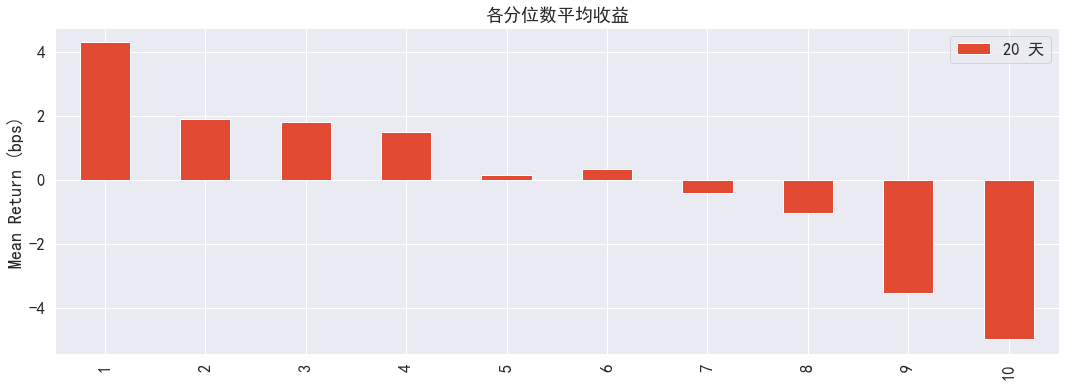

In [15]:
# 分位数收益率
basic_far['3M'].plot_quantile_returns_bar(demeaned=1)

## 动量因子改进思路

上文对常见的动量因子做了比较深入的分析，也可以发现动量因子的确具 有很高的IC绝对值和IC_IR绝对值，空头组的负向收益显著，但也存在单调性
不稳定、多头超额不显著的缺点。

下文中我们将从四个不同的角度入手，尝试对动量因子进行改造，已求寻 找到更为稳健的动量因子：

### 1.结合均线的趋势动量因子

动量因子构造时所使用的数据仅为`起始节点和末尾节点的股价数据`，对于期间的股价信息并未充分反应，因此我们尝试*采用均线*的思路，构造更好的反应股价趋势的趋势动量因子。

$MA_{jt,L}=\frac{P^{t}_{j,d-L+1}+P^{t}_{j,d-L+2}+\ldots+P^{t}_{j,d-1}+P^{t}_{j,d}}{L}$

$P^{t}_{j,d}$是指j股票在t月的每个交易日的收盘价，L是移动平均的窗口宽度。为了使得我们得到的信号是一个平稳序列，同时截面上横向可比，将移动 平均价格序列除以d日的收盘价，做标准化处理

$\widetilde{MA_{jt,L}}=\frac{MA_{jt,L}}{p^{t}_{j,d}}$

移动平均 MA 这个指标来用来识别股票未来一段时间的价格趋势，为了更 好地利用移动平均数，我们可以使用价格来将移动平均数标准化，这样就能够
将均线转化为一个截面可比的用来反应股价变化趋势的指标。

### 1.1趋势动量因子：单调性较好

在参数的设置上，我们参照常用动量因子的时长参数，选取20、60、120、 240日移动平均趋势动量因子做测试。

In [16]:
def get_momentum_mono_factor(dates,N):
    '''
    输入参数dates_befN_为各调仓日前推N日的交易日期， dates为回测期内各个月末交易日（也就是调仓日）
    dates_befN_:list
    dates:list
    -------------
    return:DataFrame
    |index-date|index-code|values|
    '''
    dict_=OrderedDict() # 创建每期存取数据字典
    for date in dates:
        
        stocks=get_stocks('000905.XSHG',date)  # 提取各交易日的成分股中满足筛选条件的股票池
        # step1:计算股票过去N日的收益率
        ## 提取各股票过去N个交易日的涨跌幅，即为过去N日内的收益率
        close=get_price(stocks,end_date=date,count=N,fields='close').close
        # step2:计算移动平均值
        ## 计算移动平均数
        MA_N=close.rolling(N).mean()
        # step3:标准化
        Z_MA=MA_N/close.loc[date]
        data=Z_MA.loc[date]
        data.name='MA_'+str(N)
        print(date,'success')
        dict_[datetime.strptime(date,"%Y-%m-%d")]=data
    datas=pd.concat(dict_.values(),keys=dict_.keys())
    datas=pd.DataFrame(datas)
    datas.index.names=['date','codes']
    return datas

In [17]:
# 此处数据提取需花费较多时间
## 将提升版动量策略的原始数据存入数据文件中，便于后期读取
momentum_mono_1M_datas=get_momentum_mono_factor(date_list,20)
momentum_mono_3M_datas=get_momentum_mono_factor(date_list,60)  
momentum_mono_6M_datas=get_momentum_mono_factor(date_list,120)  
momentum_mono_12M_datas=get_momentum_mono_factor(date_list,240)  


# 构建字典
k=['Mono_1M','Mono_3M','Mono_6M','Mono_12M']
v=[momentum_mono_1M_datas,momentum_mono_3M_datas,momentum_mono_6M_datas,
   momentum_mono_12M_datas]
mono_factor=dict(zip(k,v))

# 把计算出的因子数据写入文件 方便后续调用
pkl_file = open('mono_factor.pkl', 'wb')
pickle.dump(mono_factor, pkl_file, 0)

2007-01-31 success
2007-02-28 success
2007-03-30 success
2007-04-30 success
2007-05-31 success
2007-06-29 success
2007-07-31 success
2007-08-31 success
2007-09-28 success
2007-10-31 success
2007-11-30 success
2007-12-28 success
2008-01-31 success
2008-02-29 success
2008-03-31 success
2008-04-30 success
2008-05-30 success
2008-06-30 success
2008-07-31 success
2008-08-29 success
2008-09-26 success
2008-10-31 success
2008-11-28 success
2008-12-31 success
2009-01-23 success
2009-02-27 success
2009-03-31 success
2009-04-30 success
2009-05-27 success
2009-06-30 success
2009-07-31 success
2009-08-31 success
2009-09-30 success
2009-10-30 success
2009-11-30 success
2009-12-31 success
2010-01-29 success
2010-02-26 success
2010-03-31 success
2010-04-30 success
2010-05-31 success
2010-06-30 success
2010-07-30 success
2010-08-31 success
2010-09-30 success
2010-10-29 success
2010-11-30 success
2010-12-31 success
2011-01-31 success
2011-02-28 success
2011-03-31 success
2011-04-29 success
2011-05-31 s

2017-11-30 success
2017-12-29 success
2018-01-31 success
2018-02-28 success
2018-03-30 success
2018-04-27 success
2018-05-31 success
2018-06-29 success
2018-07-31 success
2018-08-31 success
2018-09-28 success
2018-10-31 success
2018-11-30 success
2018-12-28 success
2019-01-31 success
2019-02-28 success
2019-03-29 success
2019-04-30 success
2019-05-31 success
2019-06-28 success
2019-07-01 success
2007-01-31 success
2007-02-28 success
2007-03-30 success
2007-04-30 success
2007-05-31 success
2007-06-29 success
2007-07-31 success
2007-08-31 success
2007-09-28 success
2007-10-31 success
2007-11-30 success
2007-12-28 success
2008-01-31 success
2008-02-29 success
2008-03-31 success
2008-04-30 success
2008-05-30 success
2008-06-30 success
2008-07-31 success
2008-08-29 success
2008-09-26 success
2008-10-31 success
2008-11-28 success
2008-12-31 success
2009-01-23 success
2009-02-27 success
2009-03-31 success
2009-04-30 success
2009-05-27 success
2009-06-30 success
2009-07-31 success
2009-08-31 s

In [7]:
# 读取因子数据文件
pkl_file = open('mono_factor.pkl', 'rb')
mono_factor = pickle.load(pkl_file)
pkl_file.close()

In [19]:
# 使用获取的因子值进行单因子分析
## 设置调仓周期
periods=20
## 设置分层数量
quantiles=10
## 分析
far_mono_1M = analyze_factor(factor=mono_factor['Mono_1M'].MA_20, start_date=start, end_date=end, weight_method='avg', industry='sw_l1', quantiles=quantiles, periods=periods)
far_mono_3M = analyze_factor(factor=mono_factor['Mono_3M'].MA_60, start_date=start, end_date=end, weight_method='avg', industry='sw_l1', quantiles=quantiles, periods=periods)
far_mono_6M = analyze_factor(factor=mono_factor['Mono_6M'].MA_120, start_date=start, end_date=end, weight_method='avg', industry='sw_l1', quantiles=quantiles, periods=periods)
far_mono_12M = analyze_factor(factor=mono_factor['Mono_12M'].MA_240, start_date=start, end_date=end, weight_method='avg', industry='sw_l1', quantiles=quantiles, periods=periods)


In [20]:
# 构建因子分析字典
k=['Mono_1M','Mono_3M','Mono_6M','Mono_12M']
v=[far_mono_1M,far_mono_3M,far_mono_6M,far_mono_12M]
mono_far=dict(zip(k,v))
# 保存分析后的数据
pkl_file = open('mono_far.pkl', 'wb')
pickle.dump(mono_far, pkl_file, 0)

In [8]:
# 读取分析文件
pkl_file = open('mono_far.pkl', 'rb')
mono_far = pickle.load(pkl_file)
pkl_file.close()

月度调仓周期中Mini_3M的收益率最高，多空组合的夏普达到了了12.2，单调性得分兵不高，仅Mono_12M超过了3分。

In [9]:
trans2period(mono_far,20)

,IC,IC_IR,LongShort_sharpe,MONO_Score,Turnover
Mono_1M,0.039852,0.056369,8.450311,1.876048,0.930611
Mono_3M,0.051695,0.076417,10.843270,1.824382,0.929609
Mono_6M,0.053139,0.074074,11.392015,2.818863,0.926554
Mono_12M,0.045672,0.064755,10.714378,3.184995,0.929737


下图中可以看出Mono_3M因子1至5组的超额收益率单调性较高，6至10组单调性较弱。

<Figure size 432x288 with 0 Axes>

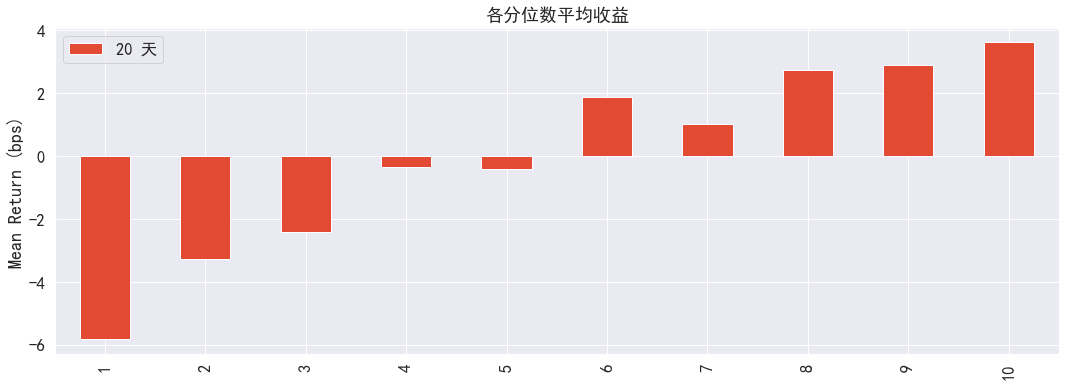

In [23]:
# 分位数收益率
mono_far['Mono_3M'].plot_quantile_returns_bar(demeaned=1)

趋势动量因子月度IC序列

<Figure size 432x288 with 0 Axes>

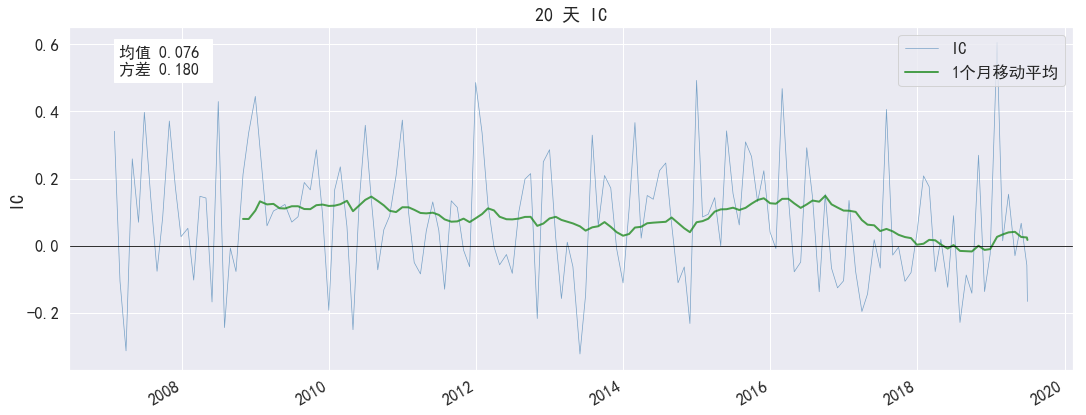

In [24]:
# IC序列
mono_far['Mono_3M'].plot_ic_ts(method='rank')

### 2.剥离流动性因素后的提纯动量因子

到采用截面中性化的方法，将衡量散户 集中程度的流动性因素从原始动量因子中剥离

In [25]:
# 此处数据提取需花费较多时间
## 将基础版动量策略的原始数据存入数据文件中，便于后期读取
momentum_1M_Neu=get_momentum_factor(date_list,20,True)  
momentum_3M_Neu=get_momentum_factor(date_list,60,True)  
momentum_6M_Neu=get_momentum_factor(date_list,120,True)  
momentum_12M_Neu=get_momentum_factor(date_list,240,True)  
momentum_24M_Neu=get_momentum_factor(date_list,480,True)  


2007-01-31 success
2007-02-28 success
2007-03-30 success
2007-04-30 success
2007-05-31 success
2007-06-29 success
2007-07-31 success
2007-08-31 success
2007-09-28 success
2007-10-31 success
2007-11-30 success
2007-12-28 success
2008-01-31 success
2008-02-29 success
2008-03-31 success
2008-04-30 success
2008-05-30 success
2008-06-30 success
2008-07-31 success
2008-08-29 success
2008-09-26 success
2008-10-31 success
2008-11-28 success
2008-12-31 success
2009-01-23 success
2009-02-27 success
2009-03-31 success
2009-04-30 success
2009-05-27 success
2009-06-30 success
2009-07-31 success
2009-08-31 success
2009-09-30 success
2009-10-30 success
2009-11-30 success
2009-12-31 success
2010-01-29 success
2010-02-26 success
2010-03-31 success
2010-04-30 success
2010-05-31 success
2010-06-30 success
2010-07-30 success
2010-08-31 success
2010-09-30 success
2010-10-29 success
2010-11-30 success
2010-12-31 success
2011-01-31 success
2011-02-28 success
2011-03-31 success
2011-04-29 success
2011-05-31 s

2017-11-30 success
2017-12-29 success
2018-01-31 success
2018-02-28 success
2018-03-30 success
2018-04-27 success
2018-05-31 success
2018-06-29 success
2018-07-31 success
2018-08-31 success
2018-09-28 success
2018-10-31 success
2018-11-30 success
2018-12-28 success
2019-01-31 success
2019-02-28 success
2019-03-29 success
2019-04-30 success
2019-05-31 success
2019-06-28 success
2019-07-01 success
2007-01-31 success
2007-02-28 success
2007-03-30 success
2007-04-30 success
2007-05-31 success
2007-06-29 success
2007-07-31 success
2007-08-31 success
2007-09-28 success
2007-10-31 success
2007-11-30 success
2007-12-28 success
2008-01-31 success
2008-02-29 success
2008-03-31 success
2008-04-30 success
2008-05-30 success
2008-06-30 success
2008-07-31 success
2008-08-29 success
2008-09-26 success
2008-10-31 success
2008-11-28 success
2008-12-31 success
2009-01-23 success
2009-02-27 success
2009-03-31 success
2009-04-30 success
2009-05-27 success
2009-06-30 success
2009-07-31 success
2009-08-31 s

In [26]:
# 构建字典
k=['Neu_1M','Neu_3M','Neu_6M','Neu_12M','Neu_24M']
v=[momentum_1M_Neu,momentum_3M_Neu,momentum_6M_Neu,momentum_12M_Neu,momentum_24M_Neu]
Neu_fartor=dict(zip(k,v))

# 把计算出的因子数据写入文件 方便后续调用
pkl_file = open('Neu_factor.pkl', 'wb')
pickle.dump(Neu_fartor, pkl_file, 0)

In [9]:
# 读取因子数据文件
pkl_file = open('Neu_factor.pkl', 'rb')
Neu_factor = pickle.load(pkl_file)
pkl_file.close()

In [28]:
# 使用获取的因子值进行单因子分析
## 设置调仓周期
periods=20
## 设置分层数量
quantiles=10
## 分析
far_Neu_1M = analyze_factor(factor=Neu_factor['Neu_1M'].loc[:,'returns'], start_date=start, end_date=end, weight_method='avg', industry='sw_l1', quantiles=quantiles, periods=periods)
far_Neu_3M = analyze_factor(factor=Neu_factor['Neu_3M'].loc[:,'returns'], start_date=start, end_date=end, weight_method='avg', industry='sw_l1', quantiles=quantiles, periods=periods)
far_Neu_6M = analyze_factor(factor=Neu_factor['Neu_6M'].loc[:,'returns'], start_date=start, end_date=end, weight_method='avg', industry='sw_l1', quantiles=quantiles, periods=periods)
far_Neu_12M = analyze_factor(factor=Neu_factor['Neu_12M'].loc[:,'returns'], start_date=start, end_date=end, weight_method='avg', industry='sw_l1', quantiles=quantiles, periods=periods)
far_Neu_24M = analyze_factor(factor=Neu_factor['Neu_24M'].loc[:,'returns'], start_date=start, end_date=end, weight_method='avg', industry='sw_l1', quantiles=quantiles, periods=periods)

In [29]:
# 构建字典
k=['Neu_1M','Neu_3M','Neu_6M','Neu_12M','Neu_24M']
v=[far_Neu_1M,far_Neu_3M,far_Neu_6M,far_Neu_12M,far_Neu_24M]
Neu_far=dict(zip(k,v))

# 保存分析后的数据
pkl_file = open('Neu_far.pkl', 'wb')
pickle.dump(Neu_far, pkl_file, 0)

In [4]:
# 读取分析文件
pkl_file = open('Neu_far.pkl', 'rb')
Neu_far = pickle.load(pkl_file)
pkl_file.close()

In [10]:
# 去流动性因子信息
trans2period(Neu_far,20)

,IC,IC_IR,LongShort_sharpe,MONO_Score,Turnover
Neu_1M,-0.049441,-0.068072,-8.622452,2.194422,0.929800
Neu_3M,-0.047448,-0.061655,-8.362406,2.650140,0.929090
Neu_6M,-0.038114,-0.051695,-7.495754,2.562544,0.930529
Neu_12M,-0.031491,-0.043567,-5.630657,2.577352,0.932615
Neu_24M,-0.030253,-0.045131,-7.141141,2.151828,0.931270


### 2.1提纯动量因子单调性提升明显，多空年化收益提高

将因子做中性化处理，剥离 流动性对动量因子的影响。中性化前后的因子表现对比如下所示：

In [49]:
pd.concat([trans2period(Neu_far,20).iloc[0,:],
        trans2period(basic_far,20).iloc[0,:]],axis=1).T

,IC,IC_IR,LongShort_sharpe,MONO_Score,Turnover
Neu_1M,-0.049441,-0.068072,-8.622452,2.194422,0.929800
1M,-0.045512,-0.066641,-7.728916,2.012446,0.930497


提纯后的动量因子 Neu_1M 单调性改善显著，且多空夏普从8.84提升至10.15,单调性得分也有所提升。

提纯后的多空净值为0.1353,原始因子多空收净值为0.1240


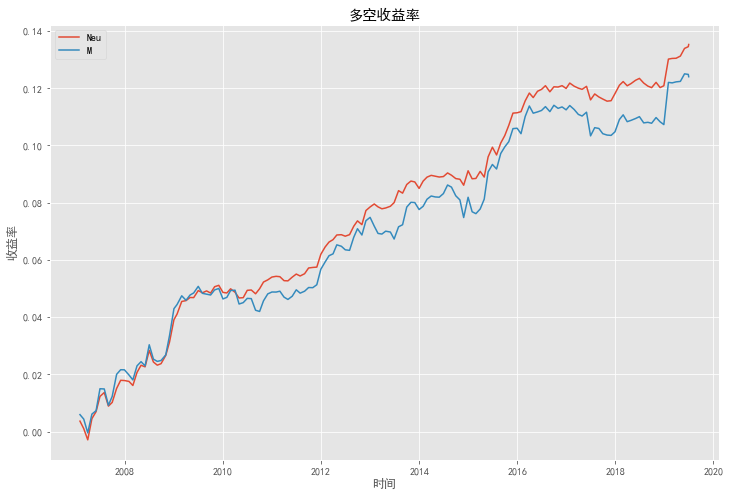

In [32]:
neu_mean, _ = Neu_far['Neu_1M'].compute_mean_returns_spread (upper_quant=1,lower_quant=10,by_date=True,demeaned=True)
mean, _ = basic_far['1M'].compute_mean_returns_spread (upper_quant=1,lower_quant=10,by_date=True,demeaned=True)

neu_cum=neu_mean.cumsum()
cum=mean.cumsum()

print('提纯后的多空净值为%2.4f,原始因子多空收净值为%2.4f'%(neu_cum.iloc[-1][0],cum.iloc[-1][0]))
plt.figure(figsize=(12,8))
plt.title("多空收益率")
plt.xlabel("时间")
plt.ylabel("收益率")

plt.plot(neu_cum,label="Neu")
plt.plot(cum,label="M")
plt.legend()


<Figure size 432x288 with 0 Axes>

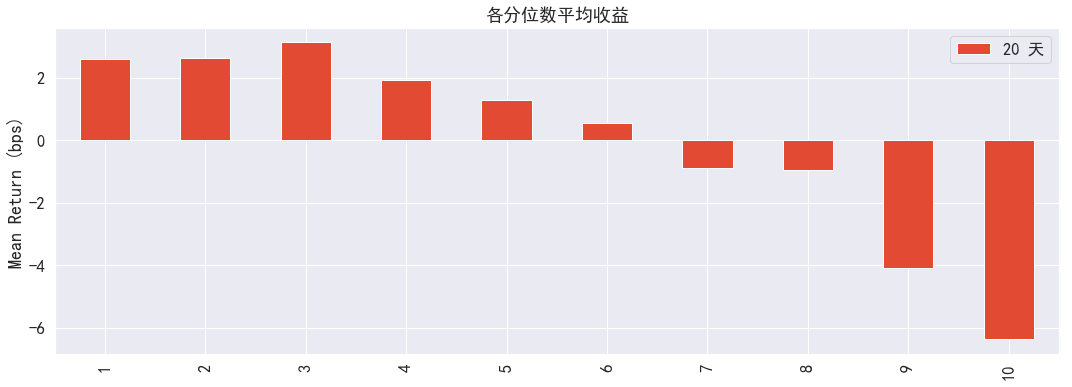

In [33]:
Neu_far['Neu_1M'].plot_quantile_returns_bar(demeaned=True)

剥离流动性后的提纯动量因子多空收益改善显著，且多头的稳定性 有比较明显的提升，是比较值得关注的动量因子改造和应用方式。

## 3.风格中性后的残差动量因子

传统的价格动量效应，其实包含了对经典Fama-French 三因子的较高暴露。反之，基于残差的动量组合，由于排序标准是剔除了承担系统性风险所获补偿的超额收益，因此，据此构造的组合，将不会对风险因子有系统性的暴露，恰恰相反，该组合是纯粹基于股票的异质性表现来构造的。异质性收益与总收益类似，也表现出一定的动量（反转）特征。 下面我们就将基于这一理论，测试基于股票异质性收益的残差动量因子在中证500中的表现。

### 3.1残差动量因子：稳定性略有提升

使用 Fama & French 的三因子模型为每个股票来估算残差回报。采用相对简单的直接回归取残差的方法。假设当前时刻为 t 月月末的最后一个交易日，对于单只股票而言，我们将其 t-35 月到 t 月（共 36 个月）个股月度收益率对 Fama-French 三因子进行时间序列回归：

$ r_{i,t}=\alpha_i+m_iMKT_T+s_iSMB_t+h_iHML_t+\epsilon_{i,t}$

其中：SMB 为小盘股组合和大盘股组合的收益率之差，组合日收益率的 计算采用流通市值加权。HML 为高BP组合和低BP组合的收益率之差，组合日收益率的计算采用对数收益率。根据上述回归得到的残差变量即可认为是该股票在剔除了已知风格因子影响后的特质收益。

由于A股市场动量因子表现的特殊性，即短期反转效应显著强于动量效应且选股能力突出。因此我们这里将从短期动量入手，尝试直接采用当期残差变量作为剔除风格影响后的特质收益动量因子，我们命名为Momentum_1M_Resid

In [285]:
import statsmodels.api as sm
from statsmodels import regression

# 计算Fama French残差
def Cal_FF_resid (stocks,tradDate,N,rf):
    '''
    stocks:list
    tradDate:str,yyyy-mm-dd
    N：int tradeDate前N天
    rf:fload 无风险利率
    -----------
    return:df
    |index-code|values|
    '''
    LoS=len(stocks)
    #查询三因子/五因子的语句
    q = query(
        valuation.code,
        valuation.circulating_cap, ## 用的流通市值
        (balance.total_owner_equities/valuation.circulating_cap/100000000.0).label("BTM"),  # 获取数据并重命名。计算BTM
        indicator.roe,
        balance.total_assets.label("Inv")
    ).filter(
        valuation.code.in_(stocks)
    )
    
    df = get_fundamentals(q,tradDate)
    
    #计算5因子再投资率的时候需要跟一年前的数据比较，所以单独取出计算
    befday=get_trade_days(end_date=tradDate,count=253)[0]
    ldf=get_fundamentals(q,befday)
    # 若前一年的数据不存在，则暂且认为Inv=0
    if len(ldf)==0:
        ldf=df
    df["Inv"]=np.log(df["Inv"]/ldf["Inv"])
    
    # 选出特征股票组合
    try:
        S=df.sort('circulating_cap')['code'][:LoS/3]
        B=df.sort('circulating_cap')['code'][LoS-LoS/3:]
        L=df.sort('BTM')['code'][:LoS/3]
        H=df.sort('BTM')['code'][LoS-LoS/3:]
        W=df.sort('roe')['code'][:LoS/3]
        R=df.sort('roe')['code'][LoS-LoS/3:]
        C=df.sort('Inv')['code'][:LoS/3]
        A=df.sort('Inv')['code'][LoS-LoS/3:]
    except AttributeError:
        S=df.sort_values('circulating_cap')['code'][:int(LoS/3)]
        B=df.sort_values('circulating_cap')['code'][LoS-int(LoS/3):]
        L=df.sort_values('BTM')['code'][:int(LoS/3)]
        H=df.sort_values('BTM')['code'][LoS-int(LoS/3):]
        W=df.sort_values('roe')['code'][:int(LoS/3)]
        R=df.sort_values('roe')['code'][LoS-int(LoS/3):]
        C=df.sort_values('Inv')['code'][:int(LoS/3)]
        A=df.sort_values('Inv')['code'][LoS-int(LoS/3):]
    
    # 获得样本期间的股票价格并计算日收益率
    df2 = get_price(stocks,end_date=tradDate,count=N,fields='close')['close']
    # 0*df2[1:]主要是方便日期对齐并返回一个df
    df3=np.diff(np.log(df2),axis=0)+0*df2[1:]
    
    #求因子的值
    SMB=sum(df3[S].T)/len(S)-sum(df3[B].T)/len(B)
    HMI=sum(df3[H].T)/len(H)-sum(df3[L].T)/len(L)
    RMW=sum(df3[R].T)/len(R)-sum(df3[W].T)/len(W)
    CMA=sum(df3[C].T)/len(C)-sum(df3[A].T)/len(A)
    
    #用中证500作为大盘基准 数据从2008-1-16开始
    dp=get_price('000905.XSHG',end_date=tradDate,count=N,fields='close')['close']
    RM=diff(np.log(dp))-rf/252
    
    #将因子们计算好并且放好
    X=pd.DataFrame({"RM":RM,"SMB":SMB,"HMI":HMI,"RMW":RMW,"CMA":CMA})
    #取前3个因子为策略因子
    factor_flag=["RM","SMB","HMI","RMW","CMA"][:3]
    #print (factor_flag)
    X=X[factor_flag]
    
    # 对样本数据进行线性回归并计算ai
    t_resid=[0.0]*LoS
    for i in range(LoS):
        t_stock=stocks[i]
        sample=pd.DataFrame
        #np.linalg.lstsq(X,y)[0]==results.params
        # 将中证500 2008-1-16前的空白数据填充为0
        X=X.fillna(0)
        #t_r=linreg(X,df3[t_stock]-rf/252,len(factor_flag))
        t_r=np.linalg.lstsq(X,df3[t_stock]-rf/252)
        t_resid[i]=t_r[1][0]
    
    #这个scores就是alpha 
    resids=pd.DataFrame({'code':stocks,'resid':t_resid})
    return resids

# 辅助线性回归的函数 Cal_FF调用
def linreg(X,Y,columns=3):
    '''
    辅助线性回归的函数
    X:list,array,DataFrame 回归自变量 
    Y:list,array,DataFrame 回归因变量
    -------
    return：list 
    '''
    X=sm.add_constant(array(X))
    Y=array(Y)
    if len(Y)>1:
        results = regression.linear_model.OLS(Y, X).fit()
        #return results.resid[-1] # 获取当期残差
        #return results.params
    else:
        return [float("nan")]#*(columns+1)

# 获取因子    
def get_Momentum_resid(dateList):
    dict_=OrderedDict()
    for d in dateList:
        print(d,'success')
        stocks=get_stocks('000905.XSHG',d)
        data=Cal_FF_resid(stocks,d,20,0.03)
        dict_[datetime.strptime(d,"%Y-%m-%d")]=data.set_index('code')
    datas=pd.concat(dict_.values(),keys=dict_.keys())
    datas.index.names=['date','codes']
    return datas

In [286]:
# 获取因子数据
Momentum_resid=get_Momentum_resid(date_list)
# 保存因子的数据
pkl_file=open('momentum_resid.plk','wb')
pickle.dump(Momentum_resid, pkl_file, 0)

2007-01-31 success
2007-02-28 success
2007-03-30 success
2007-04-30 success
2007-05-31 success
2007-06-29 success
2007-07-31 success
2007-08-31 success
2007-09-28 success
2007-10-31 success
2007-11-30 success
2007-12-28 success
2008-01-31 success
2008-02-29 success
2008-03-31 success
2008-04-30 success
2008-05-30 success
2008-06-30 success
2008-07-31 success
2008-08-29 success
2008-09-26 success
2008-10-31 success
2008-11-28 success
2008-12-31 success
2009-01-23 success
2009-02-27 success
2009-03-31 success
2009-04-30 success
2009-05-27 success
2009-06-30 success
2009-07-31 success
2009-08-31 success
2009-09-30 success
2009-10-30 success
2009-11-30 success
2009-12-31 success
2010-01-29 success
2010-02-26 success
2010-03-31 success
2010-04-30 success
2010-05-31 success
2010-06-30 success
2010-07-30 success
2010-08-31 success
2010-09-30 success
2010-10-29 success
2010-11-30 success
2010-12-31 success
2011-01-31 success
2011-02-28 success
2011-03-31 success
2011-04-29 success
2011-05-31 s

In [11]:
# 读取因子数据
pkl_file=open('momentum_resid.plk','rb')
Momentum_resid = pickle.load(pkl_file)
pkl_file.close()

In [11]:
# 使用获取的因子值进行单因子分析
## 设置调仓周期
periods=20
## 设置分层数量
quantiles=10
far_resid=analyze_factor(Momentum_resid.iloc[:,0],start_date=start, end_date=end, 
                         weight_method='avg', industry='sw_l1', quantiles=quantiles, periods=periods)

In [12]:
# 储存分析后的数据
pkl_file=open('far_resid.plk','wb')
pickle.dump(far_resid,pkl_file,0)

In [12]:
# 读取分析后的数据
pkl_file=open('far_resid.plk','rb')
far_resid=pickle.load(pkl_file)
pkl_file.close()

风格中性后的残差动量因子IC均值略高于原始动量因子，但IC_IR波动率得到有效降低，从原始的0.159下降到0.121，IC_IR也有所提升，因子的稳定性提升较为明显。但多空夏普有所下降，且单调性得分也有所下降。

In [48]:
a=factor_report(basic_far['1M'])
b=factor_report(mono_far['Mono_1M'])
c=factor_report(Neu_far['Neu_1M'])
d=factor_report(far_resid)

info_df=pd.concat([a,b,c,d],axis=0)
info_df.index=['1M','Mono_1M','Neu_1M','1M_resid']
info_df

,IC,IC_IR,LongShort_sharpe,MONO_Score,Turnover
1M,-0.045512,-0.066641,-7.728916,2.012446,0.930497
Mono_1M,0.039852,0.056369,8.450311,1.876048,0.930611
Neu_1M,-0.049441,-0.068072,-8.622452,2.194422,0.929800
1M_resid,-0.061575,-0.099514,-8.417649,1.708907,0.922375


In [101]:
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter

# 比较不同因子的IC时序图
'''
输入参数：ic为df index为日期，colum为因子名称，values为因子值

'''
def plot_contrast_ic(ic, ax=None):

    ic = ic.copy()

    num_plots = len(ic.columns)
    if ax is None:
        f, ax = plt.subplots(num_plots, 1, figsize=(18, num_plots * 7))
        ax = np.asarray([ax]).flatten()

    ymin, ymax = (None, None)
    for a, (column_name, ic) in zip(ax, ic.iteritems()):
        title_name = column_name
        ic.plot(alpha=0.7, ax=a, lw=0.7, color='steelblue')
        rolling_mean=ic.rolling(22).mean()
        rolling_mean.plot(
            ax=a, color='forestgreen', lw=2, alpha=0.8
        )

        a.axhline(0.0, linestyle='-', color='black', lw=1, alpha=0.8)
        a.set(ylabel='IC', xlabel="")
        a.set_title("{} IC_IR波动情况".format(title_name))
        a.legend(["IC", "1个月移动平均"], loc='upper right')
        a.text(
            .05,
            .95,
            "均值 {:.3f} \n标准差 {:.3f}".format(ic.mean(), ic.std()),
            fontsize=16,
            bbox={
                'facecolor': 'white',
                'alpha': 1,
                'pad': 5
            },
            transform=a.transAxes,
            verticalalignment='top'
        )

        curr_ymin, curr_ymax = a.get_ylim()
        ymin = curr_ymin if ymin is None else min(ymin, curr_ymin)
        ymax = curr_ymax if ymax is None else max(ymax, curr_ymax)

    for a in ax:
        a.set_ylim([ymin, ymax])

    return ax

原始因子的IC_IR时序图，标准差为0.159，残差动量因子的为0.121

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002E16B15EA90>,
      dtype=object)

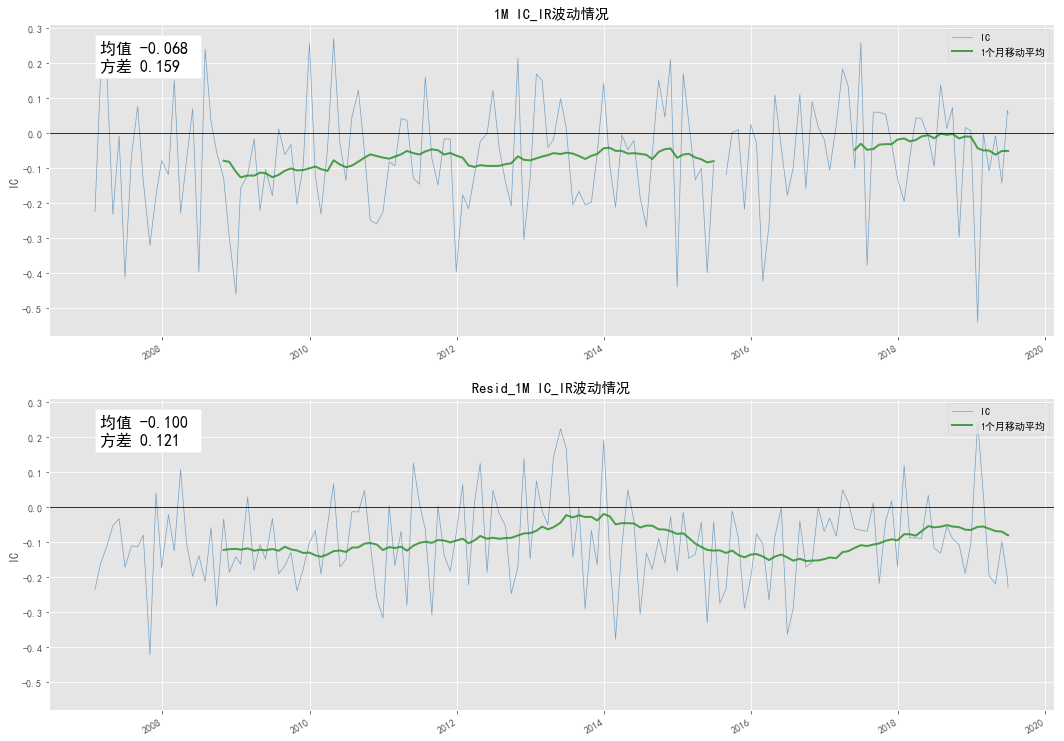

In [107]:
# 获取原始因子的IC数据
a=basic_far['1M'].calc_factor_information_coefficient(method='rank')
a.columns=['1M']
# 获取残差动量因子
b=far_resid.calc_factor_information_coefficient(method='rank')
b.columns=['Resid_1M']
# 合并
c=pd.concat([a,b],axis=1)
# 画图
plot_contrast_ic(c)

从残差动量因子的分位数收益中可以看出，仅7至10分为的单调性较好，总体来说因子单调性较差

<Figure size 432x288 with 0 Axes>

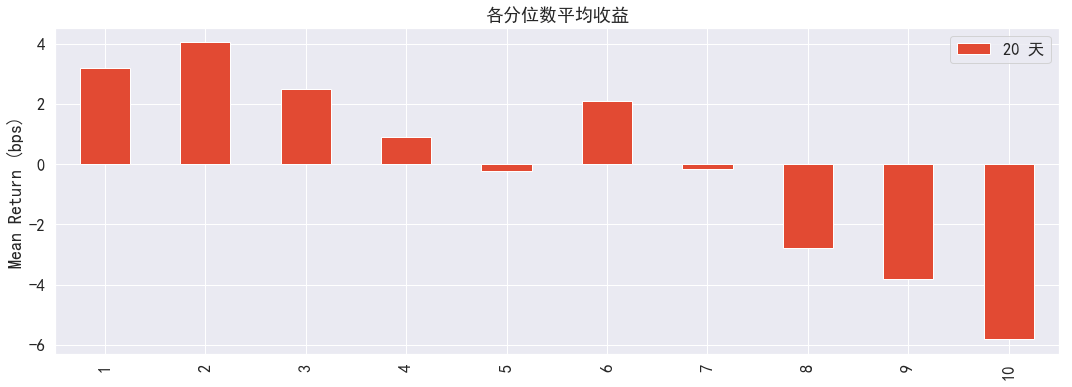

In [70]:
far_resid.plot_quantile_returns_bar(demeaned=True)

### 4.改造K线下的动量因子

基于高频数据的K线构造新方法：目前基于高频数据可以构造很多不同 的采样切片方式，目前比较主流的方式包括：ticK等分K 线，成交量等分K 线，成交额等分 K 线，信息量等分 K 线。其中 ticK 等分 K 线，成交量等分
K 线，成交额等分K线的构造方式顾名思义都非常直观。

![title](picture.png)

由于用到1分钟数据，数据量较大，我们将时间范围调整至2017年1月1日至2019年7月31日

In [6]:
# 设置时间范围
begin=datetime(2017, 1, 1)
end=datetime(2019, 8, 1)

每只股票按当日的成交额/成交量4等分构造K线

In [57]:

def get_Candlestick(start,end):
    # 获取交易日历
    dateList=get_trade_days(start_date=start,end_date=end)
    # 用于储存切片数据
    tempList=[]
    
    for day in dateList:
        # 获取股票列表
        stocks=get_stocks('000905.XSHG',day.strftime('%Y-%m-%d'))
        # 获取交易数据
        data_df=get_price(stocks,end_date=day,count=4*60,frequency='1m',fields=['volume','close','money'])
        
        volume_df=data_df.loc['volume',:,:]
        volume_df=volume_df.unstack()

        money_df=data_df.loc['money',:,:]
        money_df=money_df.unstack()

        close_df=data_df.loc['close',:,:]
        close_df=close_df.unstack()
        close_df.name='close'
            
        # 合并切片数据
        gr_v=volume_df.groupby(level=0,group_keys=False).apply(lambda x:get_cut_data(x))
        gr_v.index.names=['code','time']

        gr_m=money_df.groupby(level=0,group_keys=False).apply(lambda x:get_cut_data(x,'money'))
        gr_m.index.names=['code','time']

        slice_df=pd.concat([gr_v,gr_m],axis=1)
        slice_df=pd.concat([slice_df,close_df],axis=1,join='inner')
        
        tempList.append(slice_df)
        
        print(day,'success')
        
    df=pd.concat(tempList)
    
    pkl_file=open('get_Candlestick_d.pkl','wb')
    pickle.dump(df,pkl_file,0)
    
    print('已完成,以储存数据，数据名：get_Candlestick_d.pkl')
    
    return df

# 辅助函数供get_Candlestick调用
def get_cut_data(series,params='volume'):

    a=series.copy()
    a.name=params
    group_name=params+'_candlestick'
    
    g=pd.cut(a.cumsum(),bins=4,labels=['k1','k2','k3','k4'])
    g.name=group_name

    v=pd.concat([a,g],axis=1)
    v.drop_duplicates(group_name,keep='last',inplace=True)
    return v

In [58]:
# 提取数据
Candlestick_df=get_Candlestick(begin,end)

2017-01-03 success
2017-01-04 success
2017-01-05 success
2017-01-06 success
2017-01-09 success
2017-01-10 success
2017-01-11 success
2017-01-12 success
2017-01-13 success
2017-01-16 success
2017-01-17 success
2017-01-18 success
2017-01-19 success
2017-01-20 success
2017-01-23 success
2017-01-24 success
2017-01-25 success
2017-01-26 success
2017-02-03 success
2017-02-06 success
2017-02-07 success
2017-02-08 success
2017-02-09 success
2017-02-10 success
2017-02-13 success
2017-02-14 success
2017-02-15 success
2017-02-16 success
2017-02-17 success
2017-02-20 success
2017-02-21 success
2017-02-22 success
2017-02-23 success
2017-02-24 success
2017-02-27 success
2017-02-28 success
2017-03-01 success
2017-03-02 success
2017-03-03 success
2017-03-06 success
2017-03-07 success
2017-03-08 success
2017-03-09 success
2017-03-10 success
2017-03-13 success
2017-03-14 success
2017-03-15 success
2017-03-16 success
2017-03-17 success
2017-03-20 success
2017-03-21 success
2017-03-22 success
2017-03-23 s

2018-10-15 success
2018-10-16 success
2018-10-17 success
2018-10-18 success
2018-10-19 success
2018-10-22 success
2018-10-23 success
2018-10-24 success
2018-10-25 success
2018-10-26 success
2018-10-29 success
2018-10-30 success
2018-10-31 success
2018-11-01 success
2018-11-02 success
2018-11-05 success
2018-11-06 success
2018-11-07 success
2018-11-08 success
2018-11-09 success
2018-11-12 success
2018-11-13 success
2018-11-14 success
2018-11-15 success
2018-11-16 success
2018-11-19 success
2018-11-20 success
2018-11-21 success
2018-11-22 success
2018-11-23 success
2018-11-26 success
2018-11-27 success
2018-11-28 success
2018-11-29 success
2018-11-30 success
2018-12-03 success
2018-12-04 success
2018-12-05 success
2018-12-06 success
2018-12-07 success
2018-12-10 success
2018-12-11 success
2018-12-12 success
2018-12-13 success
2018-12-14 success
2018-12-17 success
2018-12-18 success
2018-12-19 success
2018-12-20 success
2018-12-21 success
2018-12-24 success
2018-12-25 success
2018-12-26 s

In [59]:
Candlestick_df.sort_index().head(10)

volume  ...  close
000006.XSHE 2016-12-30 09:59:00  509749.0  ...   8.88
            2016-12-30 11:20:00       NaN  ...   8.77
            2016-12-30 11:23:00   11536.0  ...   8.78
            2016-12-30 14:27:00  110025.0  ...   8.74
            2016-12-30 15:00:00  200243.0  ...   8.68
            2017-01-03 09:50:00  745252.0  ...   8.93
            2017-01-03 10:09:00   89130.0  ...   8.91
            2017-01-03 13:11:00       NaN  ...   8.86
            2017-01-03 13:12:00    7400.0  ...   8.85
            2017-01-03 15:00:00  506048.0  ...   8.89

[10 rows x 5 columns]

In [3]:
# 读取数据
pkl_file=open('get_Candlestick_d.pkl','rb')
Candlestick_df=pickle.load(pkl_file)
pkl_file.close()

改造 K线下的动量因子只有在使用等K线构造方式时才会与原始动量因子有比较大的差异，因此这里我们将主要测试等 K 线个数下不同 K 线构造的动量因子的表现。我们将K 线窗口长度设为 8，即 所有输入变量的K线窗口为 8

In [4]:
# 等成交量K线
## 筛选出等成交量K线
flag=Candlestick_df['volume_candlestick'].isna()
volume_candlestick=Candlestick_df[~flag]

## 按每8根k线计算动量因子
volume_candlestick['momentum_v']=volume_candlestick.groupby(level=0)['close'].transform(lambda x:x.pct_change(periods=8))
## index级别整理
volume_candlestick.index.names=['code','time']
volume_candlestick=volume_candlestick.swaplevel('time','code')
# convert index type
volume_candlestick.index=pd.MultiIndex.from_tuples([(ix[0].date(),ix[1]) for ix in volume_candlestick.index.tolist()])

In [61]:
# 整理成因子分析格式
volume_candlestick['id']=[str(ix[0])+str(ix[1]) for ix in volume_candlestick.index.tolist()]
volume_candlestick=volume_candlestick.drop_duplicates('id',keep='last')

In [62]:
# 因子分析
far_volume=analyze_factor(volume_candlestick['momentum_v'],start_date='2017-01-01', end_date='2019-07-31', 
                         weight_method='avg', industry='sw_l1', quantiles=10, periods=20)

In [87]:
# 等成交量K线
## 筛选出等成交量K线
flag=Candlestick_df['money_candlestick'].isna()
money_candlestick=Candlestick_df[~flag]

## 按每8根k线计算动量因子
money_candlestick['momentum_m']=money_candlestick.groupby(level=0)['close'].transform(lambda x:x.pct_change(periods=8))
## index级别整理
money_candlestick.index.names=['code','time']
money_candlestick=money_candlestick.swaplevel('time','code')
# convert index type
money_candlestick.index=pd.MultiIndex.from_tuples([(ix[0].date(),ix[1]) for ix in money_candlestick.index.tolist()])
# 整理成因子分析格式
money_candlestick['id']=[str(ix[0])+str(ix[1]) for ix in money_candlestick.index.tolist()]
money_candlestick=money_candlestick.drop_duplicates('id',keep='last')

In [65]:
# 因子分析
far_money=analyze_factor(money_candlestick['momentum_m'],start_date='2017-01-01', end_date='2019-07-31', 
                         weight_method='avg', industry='sw_l1', quantiles=10, periods=20)

等分K线的效果不是那么理想

In [66]:
# 改造k线因子分析汇总
k_far={'volume_k':far_volume,'money_k':far_money}
trans2period(k_far,20)

,IC,IC_IR,LongShort_sharpe,MONO_Score,Turnover
volume_k,0.003153,-0.009106,-0.035026,0.046618,0.893033
money_k,0.003071,-0.009095,-0.052895,0.072255,0.893025


### 5.改造基础版动量因子

使用过去60个交易日风险调整后的涨跌幅作为动量因子（它和市值因子的相关性仅为0.085），其计算公式如下所示：

### $$r_{60}-3000*\sigma ^{2}$$

其中$r_{60}$为60日涨跌幅，即60个交易日内的收益率;$\sigma$为60个交易日内收益率的标准差，代表风险。

In [5]:
# 之前get_momentum_facto已经包含此部分计算，直接使用即可
datas=get_momentum_factor(date_list,61,False)

# 储存数据
pkl_file=open('datas.pkl','wb')
pickle.dump(datas,pkl_file,0)

2007-01-31 success
2007-02-28 success
2007-03-30 success
2007-04-30 success
2007-05-31 success
2007-06-29 success
2007-07-31 success
2007-08-31 success
2007-09-28 success
2007-10-31 success
2007-11-30 success
2007-12-28 success
2008-01-31 success
2008-02-29 success
2008-03-31 success
2008-04-30 success
2008-05-30 success
2008-06-30 success
2008-07-31 success
2008-08-29 success
2008-09-26 success
2008-10-31 success
2008-11-28 success
2008-12-31 success
2009-01-23 success
2009-02-27 success
2009-03-31 success
2009-04-30 success
2009-05-27 success
2009-06-30 success
2009-07-31 success
2009-08-31 success
2009-09-30 success
2009-10-30 success
2009-11-30 success
2009-12-31 success
2010-01-29 success
2010-02-26 success
2010-03-31 success
2010-04-30 success
2010-05-31 success
2010-06-30 success
2010-07-30 success
2010-08-31 success
2010-09-30 success
2010-10-29 success
2010-11-30 success
2010-12-31 success
2011-01-31 success
2011-02-28 success
2011-03-31 success
2011-04-29 success
2011-05-31 s

In [ ]:
# 读取数据
pkl_file=open('datas.pkl','rb')
datas=pickle.load(pkl_file)
pkl_file.close()

In [12]:
# 使用获取的因子值进行单因子分析
## 设置调仓周期
periods=20
## 设置分层数量
quantiles=10
far_datas=analyze_factor(datas['momentum'],start_date=start, end_date=end, 
                         weight_method='avg', industry='sw_l1', quantiles=quantiles, periods=periods)

In [13]:
# 储存分析文件
pkl_file=open('far_datas.pkl','wb')
pickle.dump(far_datas,pkl_file,0)

In [14]:
# 读取分析文件
pkl_file=open('far_datas.pkl','rb')
far_datas=pickle.load(pkl_file)
pkl_file.close()

In [15]:
# 查看因子报告
factor_report(far_datas)

,IC,IC_IR,LongShort_sharpe,MONO_Score,Turnover
period_20,0.025917,0.052538,2.826667,2.59303,0.914342


下图为因子的十分位**超额**平均收益图，可以看到因子单调性不高，可以看到较小的因子超额收益反而更强

<Figure size 432x288 with 0 Axes>

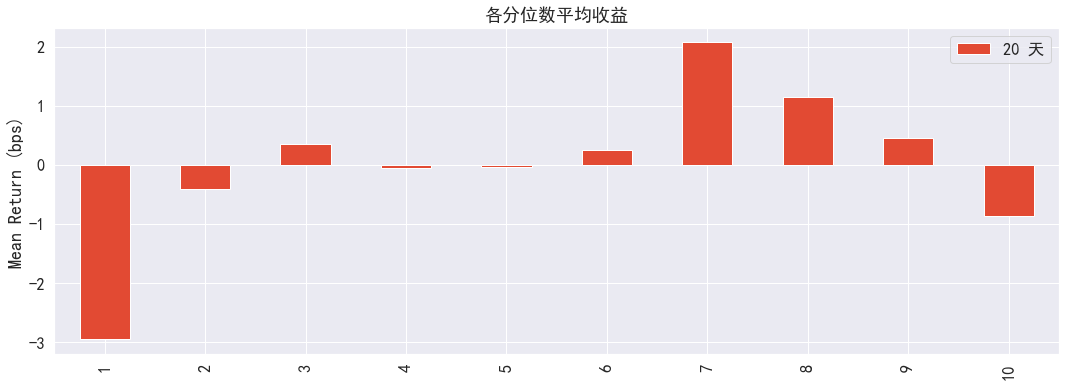

In [16]:
far_datas.plot_quantile_returns_bar(demeaned=True)

各分位数每日累积超额收益图

<Figure size 432x288 with 0 Axes>

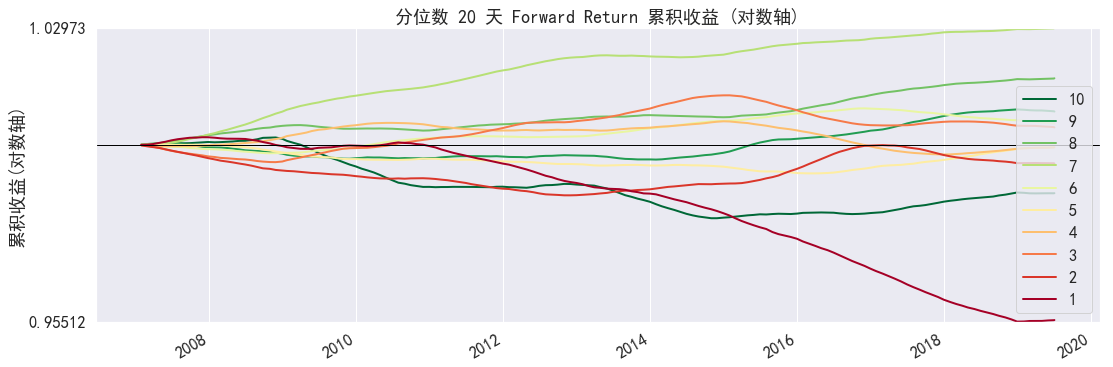

In [17]:
far_datas.plot_cumulative_returns_by_quantile(period=20, demeaned=True)

多空收益如下

<Figure size 432x288 with 0 Axes>

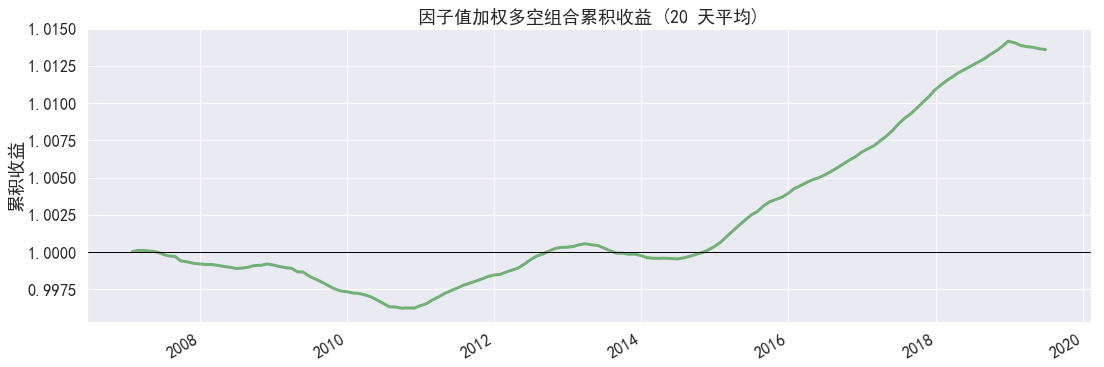

In [22]:
far_datas.plot_cumulative_returns(period=20, demeaned=True, group_adjust=False)

<Figure size 432x288 with 0 Axes>

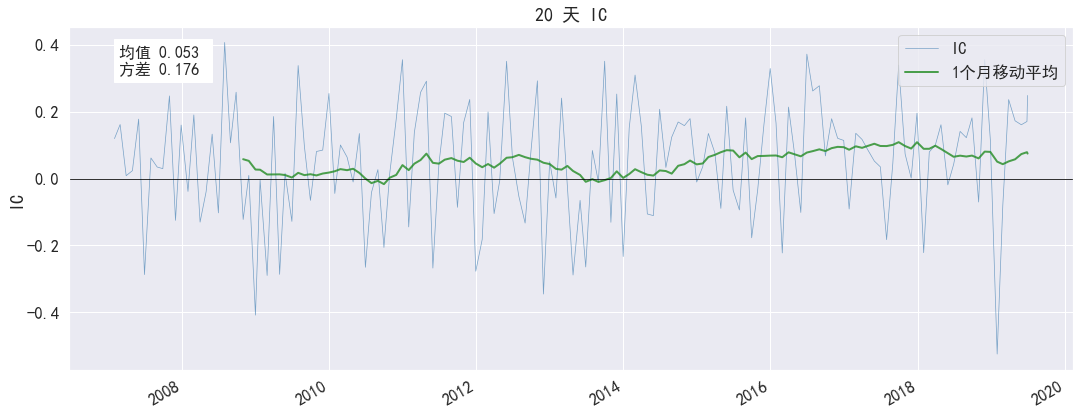

In [23]:
far_datas.plot_ic_ts(method='rank')

# 结论

1. 结合均线的趋势动量因子

    动量因子构造时所使用的数据仅为起始节点和末尾节点的股价数据，对于 期间的股价信息并未充分反应，因此我们尝试采用均线的思路，构造更好的反应股价趋势的趋势动量因子。

    **趋势动量因子均具有很高的单调性，单调性得分均可以超过3分，Mono_12M的多空夏普也很高，整体IC较原版有所提升。**


2. 剥离流动性因素后的提纯动量因子

    散户集中程度或者说流动性因素是影响动量因子效果的一个重要变量。因 此，我们采用截面中性化的方法，将衡量散户集中程度的流动性因素从原始动量因子中剥离。

    **对比基础动量因子，多空收益有所提高**


3. 风格中性后的残差动量因子

    Blitz D构建了一个基于残差的动量策略(residual momentum)，并指出残差 动量模型在诸多方面的表现都显著优于传统的价格动量。我们从短期动量入手，采用当期残差变量作为剔除市场风格影响后的特质收益动量因子。

    **IC,IC_IR对比其他动量因子有所提高**
    
    
4. 改造K线下的动量因子

    对比起来改善并不明显...